In [67]:
!which python

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/bin/python


In [68]:
!source activate py36

/usr/bin/sh: line 0: source: activate: file not found


In [69]:
import sys

#sys.path.append('/home/faske/g/anaconda3/envs/py34/lib/python3.4/site-packages')
sys.path.append('/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages')
sys.path.append("/data/gpfs/assoc/parchmanlab/tfaske/ipynb/include_utils")

import ipyparallel as ipp
import os, time
import include_utils as u
import pandas as pd
import numpy as np
import scipy as sp
import random
import numbers
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
#import vcf
from sklearn import preprocessing
from subprocess import Popen, PIPE, call, check_output
import seaborn as sns
from IPython.display import FileLink
import urllib.request as urllib2
import dill
import traceback
from pandas import Series, DataFrame
import gzip
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)
%config InlineBackend.figure_format = 'retina'
from Bio import SeqIO
#import pysam
from collections import OrderedDict, namedtuple, Counter
import operator
import multiprocessing as mp
import shutil
import tempfile
#from ipyparallel import Client
import scandir
import glob
from Bio.SeqIO.QualityIO import FastqGeneralIterator
import pickle
import re
from itertools import chain
#import Levenshtein as lv

In [70]:
vcfutils = "vcfutils.pl"
vcftools = "vcftools"
bcftools = "bcftools"
bgzip = "bgzip"
tabix = "tabix"
java = "java"
plink = "plink --noweb"

In [71]:
analysis_dir = "/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering"

In [72]:
cd $analysis_dir

/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering


In [73]:
vcf_file = os.path.join(analysis_dir, "ARTR_chr.vcf.gz")
assert os.path.exists(vcf_file)
vcf_file

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.vcf.gz'

## keep only biallelic first

In [74]:
!$vcftools --remove-indels \
--min-alleles 2 \
--max-alleles 2 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_file \
--out $'ARTR_chr.biallelic'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/ARTR_chr.vcf.gz
	--recode-INFO-all
	--max-alleles 2
	--min-alleles 2
	--out ARTR_chr.biallelic
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting VCF file...
After filtering, kept 2766918 out of a possible 2774609 Sites
Run Time = 3749.00 seconds


In [76]:
vcf_biallelic = "ARTR_chr.biallelic.recode.vcf" 
vcf_biallelic_gz = "%s.gz" % vcf_biallelic
!$bgzip -c $vcf_biallelic > {vcf_biallelic_gz}
!$tabix {vcf_biallelic_gz}

## Remove by MAF, missing, and thin next

In [118]:
!$vcftools \
--max-missing 0.7 \
--maf 0.01 \
--thin 100 \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--gzvcf \
$vcf_biallelic_gz \
--out $'ARTR_chr_miss70_thin100_MAF1'


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr.biallelic.recode.vcf.gz
	--recode-INFO-all
	--maf 0.01
	--thin 100
	--max-missing 0.7
	--out ARTR_chr_miss70_thin100_MAF1
	--recode
	--remove-filtered-all

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting VCF file...
After filtering, kept 470121 out of a possible 2766918 Sites
Run Time = 881.00 seconds


In [119]:
vcf_filtered = "ARTR_chr_miss70_thin100_MAF1.recode.vcf"
vcf_filtered_gz = "%s.gz" % vcf_filtered

In [120]:
!$bgzip -c $vcf_filtered > {vcf_filtered_gz}
!$tabix {vcf_filtered_gz}

# Remove bad_indv

by do it by mean_depth cause no missing data 

In [121]:
!$vcftools --gzvcf {vcf_filtered_gz} \
--out {vcf_filtered_gz} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr_miss70_thin100_MAF1.recode.vcf.gz
	--depth
	--out ARTR_chr_miss70_thin100_MAF1.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 708 out of 708 Individuals
Outputting Mean Depth by Individual
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 51.00 seconds


In [122]:
depth_file = vcf_filtered_gz + ".idepth"
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,470121,0.355355
1,AT2_BB_11,470121,0.246366
2,AT2_BB_12,470121,0.207864
3,AT2_BB_13,470121,0.308955
4,AT2_BB_14,470121,0.434563


In [123]:
depth_df.MEAN_DEPTH.describe()

count    708.000000
mean       0.261894
std        0.097040
min        0.000534
25%        0.193566
50%        0.256158
75%        0.330804
max        0.557031
Name: MEAN_DEPTH, dtype: float64

In [124]:
len(depth_df),len(depth_df[depth_df.MEAN_DEPTH <= .05]),len(depth_df[depth_df.MEAN_DEPTH <= .1]), len(depth_df[depth_df.MEAN_DEPTH <= .15])


(708, 15, 24, 75)

In [125]:
bad_indv = depth_df.INDV[depth_df.MEAN_DEPTH <= .1]

In [126]:
with open(os.path.join(analysis_dir, "bad_indv.txt"), "w") as o:
    o.write("INDV\n")
    for elem in bad_indv:
        o.write("%s\n" % elem)

In [127]:
!cat bad_indv.txt

INDV
AT2_EW_38
AT2_KN_90
AT2_LN_95
AT2_LN_97
AT2_OC_1
AT2_RB_2
AT2_SS_8
AT2_SS_9
AT4_DS_9
AT4_WT_1
AV2_NV_1
AV2_PL_10
AV2_SN_128
AV2_TF_149
AV4_EW_5
AV4_JU_2
AV4_LS_21
AV4_RR_6
AW4_FR_4
AW4_GB_3
AW4_JC_2
AW4_JC_3
AW4_MK_232
AW4_WJ_3


In [169]:
!$vcftools --gzvcf $vcf_filtered_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--remove {os.path.join(analysis_dir, "bad_indv.txt")} \
--out {os.path.join(analysis_dir, "snps_indv_removed")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf ARTR_chr_miss70_thin100_MAF1.recode.vcf.gz
	--remove /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/bad_indv.txt
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
Excluding individuals in 'exclude' list
After filtering, kept 684 out of 708 Individuals
Outputting VCF file...
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 597.00 seconds


In [170]:
vcf_bad_remove = os.path.join(analysis_dir, "snps_indv_removed.recode.vcf")
vcf_bad_remove_gz = vcf_bad_remove + ".gz"
!$bgzip -c {vcf_bad_remove} > {vcf_bad_remove_gz}
!$tabix {vcf_bad_remove_gz}

# Filter snps further 
this needs to be done after removing individuals


In [171]:
def get_vcf_stats(vcf_gz):
    
    stats = ['depth',
            'site-depth',
            'site-mean-depth',
            'site-quality',
            'missing-site',
            'freq',
            'counts',
            'hardy',
            'het']
    
    for stat in stats:
        !$vcftools --gzvcf $vcf_gz \
        --out $vcf_gz \
        {"--%s" % stat} 

In [172]:
get_vcf_stats(vcf_bad_remove_gz)


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting Mean Depth by Individual
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 49.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--site-depth

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting Depth for Each Site
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 52.00 seconds

VCFtools - 


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--hardy
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting HWE statistics (but only for biallelic loci)
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 54.00 seconds

VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--het
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting Individual Heterozygosity
After filtering, kept 470121 out of a possible 470121 Sites
Run Time = 47.00 s

In [173]:
#pd.set_option('display.max_columns', 100)

def get_MAF(row):
    try:
        return np.min([row.A1_freq, row.A2_freq])
    except:
        print(row)
        
def get_correction(n):
    #for finite sample size
    return (2*n)/(2*n-1)

def calculate_Fis(vals):
    try:
        data = [float(x) for x in vals.split("/")]
        assert len(data) == 3
        num_individuals = np.sum(data)
        total_alleles = 2*num_individuals
        a1_count = 2*data[0]
        a2_count = 2*data[2]
        het_count = data[1]
        a1_count += het_count
        a2_count += het_count
        a1_freq = a1_count/total_alleles
        a2_freq = a2_count/total_alleles
        assert a1_freq + a2_freq == 1.0
        He = 2 * a1_freq * a2_freq * get_correction(num_individuals)
        Ho = het_count/num_individuals
        Fis = 1 - (Ho/He)
        return Fis
    except:
        return -9

def combine_vcf_stats(filedir, prefix):
    
    hardy_files = !ls {filedir}/{prefix}.hwe
    hardy = pd.read_csv(hardy_files[0], sep="\t")

    hardy.columns = ['CHROM', 'POS', 'OBS(HOM1/HET/HOM2)', 'E(HOM1/HET/HOM2)', 'ChiSq_HWE',
       'P_HWE', 'P_HET_DEFICIT', 'P_HET_EXCESS']
    hardy.index = hardy.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_files = !ls {filedir}/{prefix}.l* | grep -v log
    loci_df = pd.concat([pd.read_csv(x, sep="\t", skiprows=0) for x in loci_files], axis=1)
    chrom_pos = loci_df.ix[:,0:2]
    
    frq_files = !ls {filedir}/{prefix}.frq* | grep -v count
    frq_data = []
    h = open(frq_files[0])
    header = h.readline().strip().split()
    for line in h:
        frq_data.append(line.strip().split('\t'))

    header = ['CHROM', 'POS', 'N_ALLELES', 'N_CHR', 'A1_FREQ', "A2_FREQ"]
    frq_df = pd.DataFrame(frq_data)
    print(frq_df.columns)
    #frq_df = frq_df.drop([6,7],axis=1)
    frq_df.columns = header
    frq_df.index = frq_df.apply(lambda x: "%s-%s" % (x.CHROM, x.POS), axis=1)
    
    loci_df = loci_df.drop(['CHROM','CHR','POS'], axis=1)
    loci_df = pd.concat([chrom_pos, loci_df], axis=1)
    loci_df.index = loci_df.apply(lambda x: "%s-%d" % (x.CHROM, x.POS), axis=1)
    
    loci_df = pd.concat([loci_df, frq_df, hardy], axis=1)
    loci_df["A1_allele"] = loci_df.apply(lambda row: row.A1_FREQ.split(":")[0], axis=1)
    loci_df["A2_allele"] = loci_df.apply(lambda row: row.A2_FREQ.split(":")[0], axis=1)
    
    loci_df["A1_freq"] = loci_df.apply(lambda row: float(row.A1_FREQ.split(":")[1]), axis=1)
    loci_df["A2_freq"] = loci_df.apply(lambda row: float(row.A2_FREQ.split(":")[1]), axis=1)
    
    loci_df['MAF'] = loci_df.apply(get_MAF, axis=1)
    loci_df = loci_df.drop(['CHROM', 'POS'], axis=1)
    
    loci_df['Fis'] = loci_df['OBS(HOM1/HET/HOM2)'].apply(calculate_Fis)
    
    return loci_df, frq_df, hardy

In [174]:
vcf_bad_remove_gz

'/data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz'

In [175]:
loci_df, frq_df, hardy = combine_vcf_stats(analysis_dir,'snps_indv_removed.recode.vcf.gz')

/data/gpfs/assoc/parchmanlab/tfaske/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


RangeIndex(start=0, stop=6, step=1)


In [176]:
loci_df

,SUM_DEPTH,SUMSQ_DEPTH,MEAN_DEPTH,VAR_DEPTH,N_DATA,N_GENOTYPE_FILTERED,N_MISS,F_MISS,QUAL,N_ALLELES,...,ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS,A1_allele,A2_allele,A1_freq,A2_freq,MAF,Fis
CM042338.1-22493,1,1,0.001462,0.001462,1368,0,0,0,7.82756,2,...,684.00000,5.952672e-205,1.000000e+00,5.776507e-205,C,G,0.500000,0.500000,0.500000,-0.998538
CM042338.1-59115,362,934,0.529240,1.086990,1368,0,0,0,999.00000,2,...,0.36772,1.000000e+00,1.000000e+00,7.063152e-01,A,T,0.022661,0.977339,0.022661,-0.022438
CM042338.1-97078,2,4,0.002924,0.005848,1368,0,0,0,35.79330,2,...,680.01170,2.099126e-202,1.000000e+00,1.978454e-202,T,G,0.499269,0.500731,0.499269,-0.995620
CM042338.1-106063,26,46,0.038012,0.065903,1368,0,0,0,999.00000,2,...,621.84560,1.621062e-174,1.000000e+00,1.620144e-174,T,C,0.505848,0.494152,0.494152,-0.952056
CM042338.1-126072,552,1596,0.807018,1.684520,1368,0,0,0,999.00000,2,...,61.89046,2.387714e-09,2.387714e-09,1.000000e+00,C,G,0.932749,0.067252,0.067252,0.301315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CM042346.1-338263844,2,4,0.002924,0.005848,1368,0,0,0,35.79330,2,...,680.01170,2.099126e-202,1.000000e+00,1.978454e-202,T,C,0.499269,0.500731,0.499269,-0.995620
CM042346.1-338268601,3,9,0.004386,0.013158,1368,0,0,0,54.99990,2,...,680.01170,2.099126e-202,1.000000e+00,1.978454e-202,A,G,0.499269,0.500731,0.499269,-0.995620
CM042346.1-338274068,1,1,0.001462,0.001462,1368,0,0,0,7.82756,2,...,684.00000,5.952672e-205,1.000000e+00,5.776507e-205,G,T,0.500000,0.500000,0.500000,-0.998538
CM042346.1-338287589,1,1,0.001462,0.001462,1368,0,0,0,5.49146,2,...,684.00000,5.952672e-205,1.000000e+00,5.776507e-205,G,A,0.500000,0.500000,0.500000,-0.998538


In [177]:
frq_df

,CHROM,POS,N_ALLELES,N_CHR,A1_FREQ,A2_FREQ
CM042338.1-22493,CM042338.1,22493,2,1368,C:0.5,G:0.5
CM042338.1-59115,CM042338.1,59115,2,1368,A:0.0226608,T:0.977339
CM042338.1-97078,CM042338.1,97078,2,1368,T:0.499269,G:0.500731
CM042338.1-106063,CM042338.1,106063,2,1368,T:0.505848,C:0.494152
CM042338.1-126072,CM042338.1,126072,2,1368,C:0.932749,G:0.0672515
...,...,...,...,...,...,...
CM042346.1-338263844,CM042346.1,338263844,2,1368,T:0.499269,C:0.500731
CM042346.1-338268601,CM042346.1,338268601,2,1368,A:0.499269,G:0.500731
CM042346.1-338274068,CM042346.1,338274068,2,1368,G:0.5,T:0.5
CM042346.1-338287589,CM042346.1,338287589,2,1368,G:0.5,A:0.5


In [178]:
hardy

,CHROM,POS,OBS(HOM1/HET/HOM2),E(HOM1/HET/HOM2),ChiSq_HWE,P_HWE,P_HET_DEFICIT,P_HET_EXCESS
CM042338.1-22493,CM042338.1,22493,0/684/0,171.00/342.00/171.00,684.00000,5.952672e-205,1.000000e+00,5.776507e-205
CM042338.1-59115,CM042338.1,59115,0/31/653,0.35/30.30/653.35,0.36772,1.000000e+00,1.000000e+00,7.063152e-01
CM042338.1-97078,CM042338.1,97078,0/683/1,170.50/342.00/171.50,680.01170,2.099126e-202,1.000000e+00,1.978454e-202
CM042338.1-106063,CM042338.1,106063,12/668/4,175.02/341.95/167.02,621.84560,1.621062e-174,1.000000e+00,1.620144e-174
CM042338.1-126072,CM042338.1,126072,608/60/16,595.09/85.81/3.09,61.89046,2.387714e-09,2.387714e-09,1.000000e+00
...,...,...,...,...,...,...,...,...
CM042346.1-338263844,CM042346.1,338263844,0/683/1,170.50/342.00/171.50,680.01170,2.099126e-202,1.000000e+00,1.978454e-202
CM042346.1-338268601,CM042346.1,338268601,0/683/1,170.50/342.00/171.50,680.01170,2.099126e-202,1.000000e+00,1.978454e-202
CM042346.1-338274068,CM042346.1,338274068,0/684/0,171.00/342.00/171.00,684.00000,5.952672e-205,1.000000e+00,5.776507e-205
CM042346.1-338287589,CM042346.1,338287589,0/684/0,171.00/342.00/171.00,684.00000,5.952672e-205,1.000000e+00,5.776507e-205


In [179]:
loci_out = os.path.join(analysis_dir,'loci_out.csv')
frq_out = os.path.join(analysis_dir,'frq_out.csv')
hardy_out = os.path.join(analysis_dir,'hardy_out.csv')

loci_df.to_csv(path_or_buf=loci_out)
frq_df.to_csv(path_or_buf=frq_out)
hardy.to_csv(path_or_buf=hardy_out)


In [180]:
loci_df.SUM_DEPTH.describe()

count    470121.000000
mean        184.597399
std         713.444358
min           0.000000
25%           1.000000
50%           2.000000
75%          21.000000
max      162196.000000
Name: SUM_DEPTH, dtype: float64

In [181]:
loci_df.MEAN_DEPTH.describe()

count    470121.000000
mean          0.269879
std           1.043048
min           0.000000
25%           0.001462
50%           0.002924
75%           0.030702
max         237.129000
Name: MEAN_DEPTH, dtype: float64

In [182]:
loci_df.QUAL.describe()

count    470121.000000
mean        288.034278
std         435.786035
min           4.799820
25%           7.827560
50%          24.294500
75%         999.000000
max         999.000000
Name: QUAL, dtype: float64

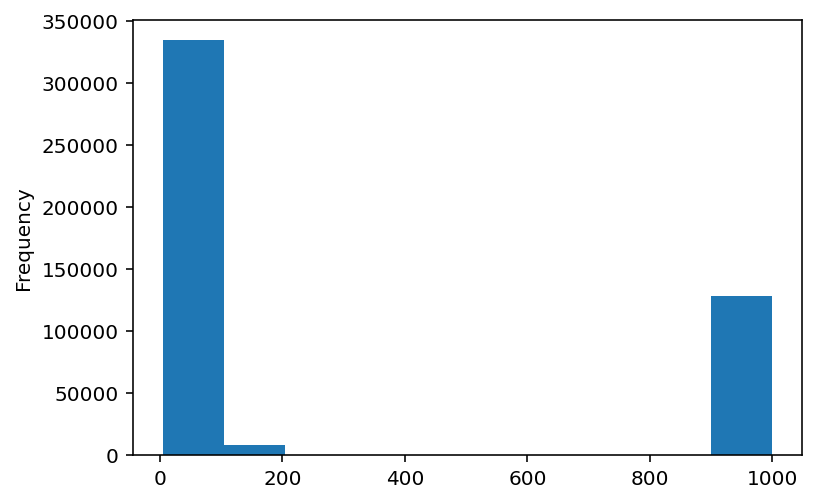

In [183]:
loci_df.QUAL.plot(kind="hist");

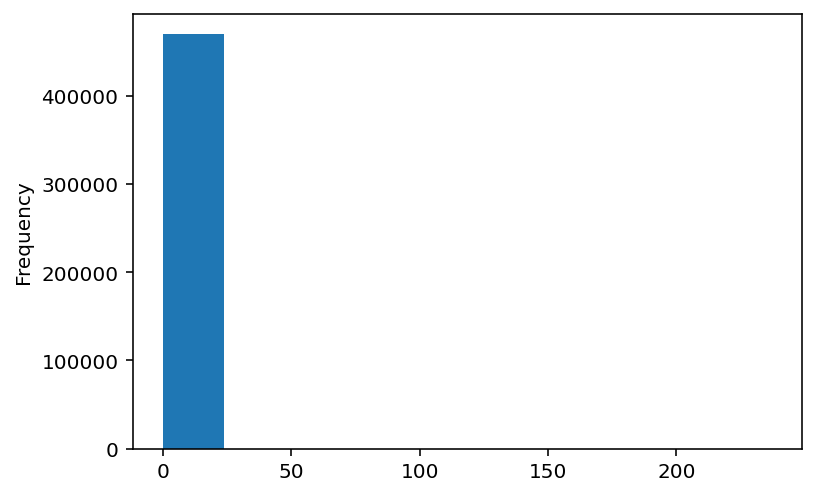

In [184]:
loci_df.MEAN_DEPTH.plot(kind="hist");

In [185]:
len(loci_df[loci_df.Fis == -9])

0

In [186]:
len(loci_df[loci_df.SUM_DEPTH <5000]),len(loci_df[loci_df.SUM_DEPTH >=500])

(469632, 55058)

In [187]:
len(loci_df[loci_df.MEAN_DEPTH > 30 ]),len(loci_df[loci_df.MEAN_DEPTH >= 1])

(17, 42765)

In [188]:
len(loci_df[loci_df.QUAL >= 20]) - len(loci_df[loci_df.QUAL >= 30])

14423

In [189]:
len(loci_df[loci_df.QUAL >  20]), len(loci_df[loci_df.QUAL > 50]), len(loci_df[loci_df.QUAL > 100])

(239462, 171227, 136633)

In [190]:
 len(loci_df[loci_df.Fis >= -0.5]), len(loci_df[loci_df.MAF < 0.01])

(91235, 28)

In [205]:
def filter_snps(df, imputed=False):
    if imputed:
        return df[(df.MAF >= 0.01) &  
                  (df.Fis > -0.5)]
    else:
        return df[(df.MEAN_DEPTH >= 1) & 
                  (df.MEAN_DEPTH < 30) & 
                  (df.QUAL >= 100) & 
                  (df.MAF >= 0.01) &
                  (df.Fis >= -0.5)]

In [206]:
#42513 with df.Fis >= -0.5
#42688 without 
loci_stage1 = filter_snps(loci_df)
loci_stage1.shape

(42513, 25)

In [207]:
with open(os.path.join(analysis_dir, "stage1_positions.txt"), "w") as o:
    for elem in loci_stage1.index:
        o.write("%s\n" % "\t".join(elem.split("-")))

In [194]:
!$vcftools --gzvcf $vcf_bad_remove_gz \
--remove-indels  \
--remove-filtered-all \
--recode \
--recode-INFO-all \
--positions {os.path.join(analysis_dir, "stage1_positions.txt")} \
--out {os.path.join(analysis_dir, "good_snps")}


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/snps_indv_removed.recode.vcf.gz
	--recode-INFO-all
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps
	--positions /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/stage1_positions.txt
	--recode
	--remove-filtered-all
	--remove-indels

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting VCF file...
After filtering, kept 42513 out of a possible 470121 Sites
Run Time = 68.00 seconds


In [195]:
snps = os.path.join(analysis_dir, "good_snps.recode.vcf")
snps_gz = snps + ".gz"
!$bgzip -c {snps} > {snps_gz}
!$tabix {snps_gz}

# Make 012

In [196]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--012


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps.recode.vcf
	--012
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Writing 012 matrix files ... Done.
After filtering, kept 42513 out of a possible 42513 Sites
Run Time = 7.00 seconds


# Get coverage per individual

In [197]:
f = os.path.join(analysis_dir, "good_snps.recode.vcf")
!$vcftools --gzvcf {f} \
--out {f} \
--depth


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps.recode.vcf
	--depth
	--out /data/gpfs/assoc/denovo/tfaske/sagebrush/SNPcall/filtering/good_snps.recode.vcf

Using zlib version: 1.2.11
After filtering, kept 684 out of 684 Individuals
Outputting Mean Depth by Individual
After filtering, kept 42513 out of a possible 42513 Sites
Run Time = 4.00 seconds


In [198]:
depth_file = os.path.join(analysis_dir, "good_snps.recode.vcf.idepth")
depth_df = pd.read_csv(depth_file, sep="\t")
depth_df.head()

,INDV,N_SITES,MEAN_DEPTH
0,AT2_BB_10,42513,2.92548
1,AT2_BB_11,42513,1.89606
2,AT2_BB_12,42513,1.61906
3,AT2_BB_13,42513,2.38941
4,AT2_BB_14,42513,3.32973


In [199]:
depth_df.MEAN_DEPTH.describe()

count    684.000000
mean       2.218168
std        0.734836
min        0.884083
25%        1.641617
50%        2.137560
75%        2.761677
max        4.543060
Name: MEAN_DEPTH, dtype: float64

# Remove unnecessary files

In [200]:
!rm *vcf